In [1]:
import os
import random
import re
import numpy as np
import shutil
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Optional
from pathlib import Path
import logging

In [2]:
rng = np.random.default_rng(seed=25) # old number=42, 152

In [3]:
data_folder = "output_31_03_2025/" # "output_21_03_2025/" ; "output_31_03_2025/" 
folder_path_outputs = '/app/nse/outputs/' + data_folder
file_path_results = '/app/nse/results/' + data_folder

In [ ]:
from datetime import datetime

def get_formatted_date():
    now = datetime.now()
    formatted_date = now.strftime("%Y_%m_%d_%H_%M")
    return formatted_date

In [ ]:
# uuid
current_date = get_formatted_date()

In [4]:
def read_data(filename):
    with open(filename, 'r') as file:
        # Skip the first three lines
        for _ in range(3):
            next(file)
        
        # Read the rest of the file
        data = np.loadtxt(file)
    
    return data

In [5]:
def get_folder_paths(folder_path, folder_pattern):
    folder_list = [folder_path + f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and re.search(folder_pattern, f)]
    folder_list.sort(key=os.path.getctime)
    return folder_list

In [6]:
def extract_number(filename):
    match = re.search(r'C\[(\d+)\]-avg-\.plt', filename)
    return int(match.group(1)) if match else float('inf') 

In [7]:
def sort_filenames(filenames):
    return sorted(filenames, key=extract_number)

In [8]:
def get_filenames(file_path, file_pattern):
    file_list = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f)) and re.search(file_pattern, f)]
    file_list = sort_filenames(file_list)
    return file_list

In [9]:
def add_text_to_file(file_path, line_number, text_to_add):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Insert the new text at the specified line number
    lines.insert(line_number - 1, text_to_add + '\n')

    # Write the modified contents back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

In [10]:
def change_lines(file_path, lines_to_change, changed_lines):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    i = 0
    for idx, line in enumerate(lines):
        if re.search(lines_to_change[i], line):
            lines[idx] = changed_lines[i]
            i+=1
            if i == len(changed_lines):
                break
    if len(changed_lines) != i:
        print(len(changed_lines) - i, "lines not changed")
     
    # Write the modified contents back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

In [11]:
outputs_folder_names = get_folder_paths(folder_path_outputs, "output*")

In [ ]:
@dataclass
class TracerData:
    """Data class for storing tracer-specific information."""
    index: int
    y_pos: float
    z_pos: float
    value: float

@dataclass
class ConfigData:
    """Data class for storing configuration parameters."""
    U: float
    z0_m: float
    surface_value: float
    grad_z: float
    value:float
    tracers: List[TracerData]
    experiment_id: str

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class ConfigParser:
    
    def __init__(self, config_path: str, experiment_num: str):
        self.config_path = Path(config_path)
        self.config_text = None
        self.config_data = None
        self.experiment_id = experiment_num
    def read_config(self) -> None:
        try:
            with open(self.config_path, 'r') as f:
                self.config_text = f.read()
            logger.info(f"Successfully read configuration file: {self.config_path}")
        except FileNotFoundError:
            logger.error(f"Configuration file not found: {self.config_path}")
            raise
        except Exception as e:
            logger.error(f"Error reading configuration file: {e}")
            raise

    def _extract_float_value(self, pattern: str) -> float:
        match = re.search(pattern, self.config_text)
        if not match:
            raise ValueError(f"Could not find value matching pattern: {pattern}")
        return float(match.group(1))

    def _parse_tracers(self) -> List[TracerData]:
        tracers = []
        tracer_sections = re.finditer(
            r'tracer_(\d+)\s*{[^}]*}\s*#[^]]*]\s*point_emission\s*{([^}]*)}', 
            self.config_text
        )
        
        for section in tracer_sections:
            index = int(section.group(1))
            tracer_text = section.group(2)
            
            try:
                value = float(re.search(r'value\s*=\s*([0-9.]+)', tracer_text).group(1))
                y_pos = float(re.search(r'ypos\s*=\s*[^+]*\+\s*([0-9.]+)', tracer_text).group(1))
                z_pos = float(re.search(r'zpos\s*=\s*([0-9.]+)', tracer_text).group(1))
                
                tracers.append(TracerData(index, y_pos, z_pos, value))
            except Exception as e:
                logger.error(f"Error parsing tracer {index}: {e}")
                raise
                
        return sorted(tracers, key=lambda x: x.index)

    def parse(self) -> ConfigData:
        if not self.config_text:
            self.read_config()

        try:
            # Extract main configuration values
            U = self._extract_float_value(r'U\s*=\s*([0-9.]+)')
            z0_m = self._extract_float_value(r'z0_m\s*=\s*([0-9.]+)')
            surface_value = self._extract_float_value(r'surface_value\s*=\s*([0-9.]+)')
            grad_z = self._extract_float_value(r'grad_z\s*=\s*([0-9.]+)')
            value = self._extract_float_value(r'value\s*=\s*(-[0-9.]+);	# sensible heat flux')
            # Parse tracer data
            tracers = self._parse_tracers()
            experiment_id = self.experiment_id
            self.config_data = ConfigData(U, z0_m, surface_value, grad_z, value, tracers, experiment_id)
            logger.info("Successfully parsed configuration data")
            
            return self.config_data
            
        except Exception as e:
            logger.error(f"Error parsing configuration: {e}")
            raise

class DataAnalyzer:
    
    def __init__(self, config_data: ConfigData):
        self.config_data = config_data

    def create_dataframe(self) -> pd.DataFrame:
        data = []
        
        # Create rows for each tracer
        for tracer in self.config_data.tracers:
            row = {
                'experiment_num': self.config_data.experiment_id,
                'Tracer': tracer.index,
                'y': tracer.y_pos,
                'z': tracer.z_pos,
                'u': self.config_data.U,
                'power': tracer.value,
                'roughness': self.config_data.z0_m,
                'T': self.config_data.surface_value,
                'sensible_heat_flux':self.config_data.value,
                'T_grad': self.config_data.grad_z
            }
            data.append(row)
            
        return pd.DataFrame(data)

    def save_to_csv(self, output_path: str) -> None:
        df = self.create_dataframe()
        df.to_csv(output_path, index=False)
        logger.info(f"Data saved to: {output_path}")

In [ ]:
%%time
features_all = pd.DataFrame()
for idx, folder in enumerate(outputs_folder_names):
    config_path = folder + "/config.txt"
    parser = ConfigParser(config_path, experiment_num = current_date + "_" + "idx")
    features = parser.parse()
    analyzer = DataAnalyzer(features)
    features_pd = analyzer.create_dataframe()
    features_all = pd.concat([features_all, features_pd], axis=0)

2025-04-01 11:06:38,521 - INFO - Successfully read configuration file: /app/nse/outputs/output_31_03_2025/output_2025_3_30_22_45_11/config.txt
2025-04-01 11:06:38,523 - INFO - Successfully parsed configuration data
2025-04-01 11:06:38,613 - INFO - Successfully read configuration file: /app/nse/outputs/output_31_03_2025/output_2025_3_30_23_11_21/config.txt
2025-04-01 11:06:38,615 - INFO - Successfully parsed configuration data
2025-04-01 11:06:38,721 - INFO - Successfully read configuration file: /app/nse/outputs/output_31_03_2025/output_2025_3_30_23_37_29/config.txt
2025-04-01 11:06:38,722 - INFO - Successfully parsed configuration data
2025-04-01 11:06:38,799 - INFO - Successfully read configuration file: /app/nse/outputs/output_31_03_2025/output_2025_3_31_0_3_38/config.txt
2025-04-01 11:06:38,800 - INFO - Successfully parsed configuration data
2025-04-01 11:06:38,851 - INFO - Successfully read configuration file: /app/nse/outputs/output_31_03_2025/output_2025_3_31_0_29_42/config.txt


CPU times: user 201 ms, sys: 45.8 ms, total: 247 ms
Wall time: 5.1 s


In [15]:
features_all.shape

(5800, 9)

In [16]:
features_all.to_csv("features.csv", index=False)

In [23]:
feature_first = pd.read_csv('features.csv')

In [30]:
import matplotlib.pyplot as plt

In [33]:
features_all.reset_index(inplace=True)

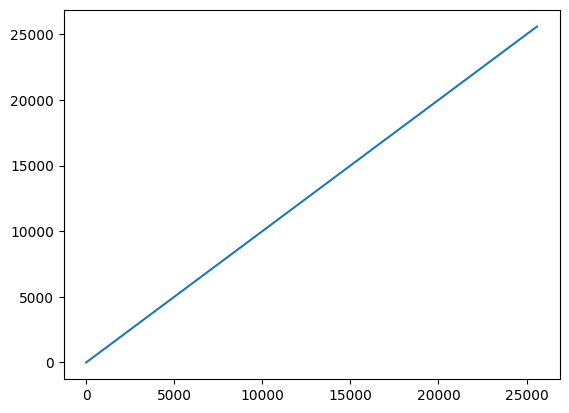

In [37]:
plt.plot(np.arange(features_all.shape[0]), feature_first.index)

In [40]:
feature_first.columns

Index(['Tracer', 'y', 'z', 'u', 'power', 'roughness', 'T',
       'sensible_heat_flux', 'T_grad'],
      dtype='object')

In [44]:
features_all.drop(columns = ['index'], inplace = True)

In [45]:
(feature_first.columns == features_all.columns).sum()

9

In [46]:
features_all.compare(feature_first)

y                        z                     u             \
              self        other        self       other      self      other   
0      1238.468349  1238.468349         NaN         NaN       NaN        NaN   
1              NaN          NaN         NaN         NaN       NaN        NaN   
2      1216.468813  1216.468813         NaN         NaN       NaN        NaN   
3       958.307090   958.307090         NaN         NaN       NaN        NaN   
4       945.380254   945.380254         NaN         NaN       NaN        NaN   
...            ...          ...         ...         ...       ...        ...   
25595  1285.234478  1277.235103   88.024219  149.660626  2.353443  12.215008   
25596   926.514176   830.117127   87.728335  119.343560  2.353443  12.215008   
25597  1228.162908  1058.587139  213.411341   69.587272  2.353443  12.215008   
25598  1197.632043   905.748190  354.899367  203.993304  2.353443  12.215008   
25599  1002.422939  1200.661892  236.122788  163.392861  2.353443  12.215008   

          power           roughness                     T              \
           self     other      self     other        self       other   
0           NaN       NaN  0.050250  0.050250  254.178518  254.178518   
1           NaN       NaN  0.050250  0.050250  254.178518  254.178518   
2      1.309081  1.309081  0.050250  0.050250  254.178518  254.178518   
3           NaN       NaN  0.050250  0.050250  254.178518  254.178518   
4           NaN       NaN  0.050250  0.050250  254.178518  254.178518   
...         ...       ...       ...       ...         ...         ...   
25595  1.161378  1.554673  0.299349  0.001917  231.638102  245.885104   
25596  1.571923  0.995379  0.299349  0.001917  231.638102  245.885104   
25597  0.878020  1.551656  0.299349  0.001917  231.638102  245.885104   
25598  1.462324  1.560396  0.299349  0.001917  231.638102  245.885104   
25599  1.212908  1.396173  0.299349  0.001917  231.638102  245.885104   

      sensible_heat_flux              T_grad            
                    self     other      self     other  
0              -0.100508 -0.100508  0.068839  0.068839  
1              -0.100508 -0.100508  0.068839  0.068839  
2              -0.100508 -0.100508  0.068839  0.068839  
3              -0.100508 -0.100508  0.068839  0.068839  
4              -0.100508 -0.100508  0.068839  0.068839  
...                  ...       ...       ...       ...  
25595          -0.165794 -0.294904  0.072592  0.097857  
25596          -0.165794 -0.294904  0.072592  0.097857  
25597          -0.165794 -0.294904  0.072592  0.097857  
25598          -0.165794 -0.294904  0.072592  0.097857  
25599          -0.165794 -0.294904  0.072592  0.097857  

[25600 rows x 16 columns]